## Part 1: Data Processing
1. Load the Dataset:

In [1]:


import pandas as pd
import re
import warnings
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from keras_preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense, BatchNormalization, GRU
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('twitter_training.csv', header=None)
df.columns = ['ID', 'Topic', 'Sentiment', 'Tweet']
df.head()


,ID,Topic,Sentiment,Tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


2. Data Cleaning:

In [3]:
# Check and handle missing values
df = df.dropna(subset=['Tweet'])

# Remove duplicates
initial_rows = len(df)
df = df.drop_duplicates(subset=['Tweet'])
print(f"b. Duplicates removed: {initial_rows - len(df)}")

# Text cleaning function
def clean_text(text):
    if pd.isna(text) or not isinstance(text, str):
        return ""
    # URLs removal
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # email addresses pattern removal
    text = re.sub(r'\S+@\S+', '', text)
    # mentions (@username) and hashtags removal
    text = re.sub(r'@\w+|#\w+', '', text)

    # special characters and digits removal
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # convert to lowercase and remove extra whitespace
    text = text.lower().strip()
    text = re.sub(r'\s+', ' ', text)
    
    return text

# applying the "clean_text" function.
df['Cleaned_Tweet'] = df['Tweet'].apply(clean_text)

# Vectorized tokenization for speed
df['Tokens'] = df['Cleaned_Tweet'].str.split()

# stop words removal
stop_words = set(stopwords.words('english'))

def fast_preprocess(tokens):
    if not isinstance(tokens, list):
        return []
    # Skip stemming for speed, just remove stop words
    return [word for word in tokens if word.lower() not in stop_words and len(word) > 1]

# Use apply with fast_preprocess
df['Processed_Tokens'] = df['Tokens'].apply(fast_preprocess)
df['Processed_Text'] = df['Processed_Tokens'].apply(lambda x: ' '.join(x))

# print(f"Data after cleaning and preprocessing:\n{df[['Tweet', 'Cleaned_Tweet', 'Processed_Text']].head()}")

b. Duplicates removed: 4505


3. Feature Engineering:

In [4]:
# Converting text to TF-IDF numerical features
tfidf_vectorizer = TfidfVectorizer(max_features=500, min_df=2, max_df=0.8)
tfidf_features = tfidf_vectorizer.fit_transform(df['Processed_Text'])

print(f"f. TF-IDF features shape: {tfidf_features.shape}")

# Creating token sequences
df['Token_Sequence'] = df['Processed_Tokens']

# Reset index
df.reset_index(drop=True, inplace=True)

f. TF-IDF features shape: (69491, 500)


## Part 2: Exploratory Data Analysis (EDA)
1. Basic Statistics:

In [5]:
print("\n1. BASIC STATISTICS")
print("-" * 70)

df['Tweet_Length'] = df['Cleaned_Tweet'].apply(len)
df['Word_Count'] = df['Processed_Tokens'].apply(len)

print(f"\na. Dataset Summary:")
print(f"   - Total tweets: {len(df):,}")
print(f"   - Unique topics: {df['Topic'].nunique()}")
print(f"   - Tweet length (avg): {df['Tweet_Length'].mean():.2f} chars")
print(f"   - Word count (avg): {df['Word_Count'].mean():.2f} words")

print(f"\nb. Sentiment Distribution:")
sentiment_counts = df['Sentiment'].value_counts()
for sentiment, count in sentiment_counts.items():
    pct = (count / len(df)) * 100
    print(f"   - {sentiment}: {count:,} ({pct:.1f}%)")


1. BASIC STATISTICS
----------------------------------------------------------------------

a. Dataset Summary:
   - Total tweets: 69,491
   - Unique topics: 32
   - Tweet length (avg): 100.77 chars
   - Word count (avg): 10.76 words

b. Sentiment Distribution:
   - Negative: 21,166 (30.5%)
   - Positive: 19,067 (27.4%)
   - Neutral: 17,042 (24.5%)
   - Irrelevant: 12,216 (17.6%)


2. VISUALIZATIONS

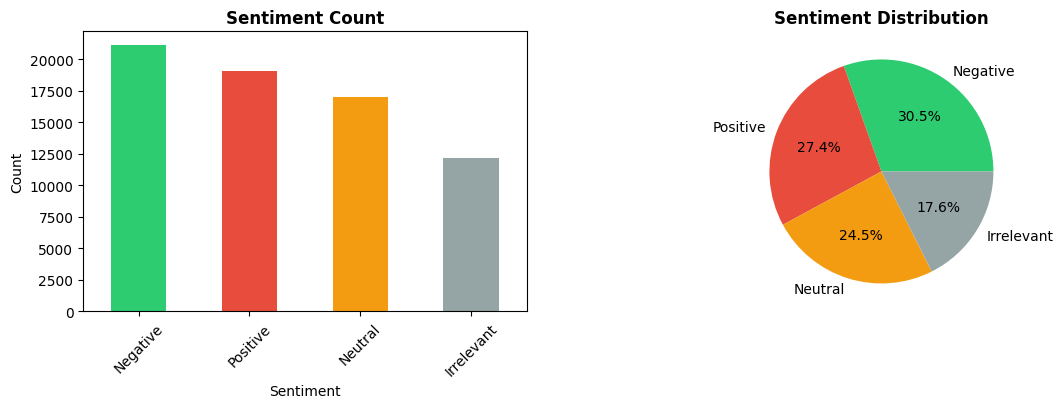

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
colors = ['#2ecc71', '#e74c3c', '#f39c12', '#95a5a6']
sentiment_counts.plot(kind='bar', ax=axes[0], color=colors[:len(sentiment_counts)])
axes[0].set_title('Sentiment Count', fontweight='bold')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

(sentiment_counts / len(df) * 100).plot(kind='pie', ax=axes[1], autopct='%1.1f%%', colors=colors[:len(sentiment_counts)])
axes[1].set_title('Sentiment Distribution', fontweight='bold')
axes[1].set_ylabel('')
plt.subplots_adjust(left=0.1, right=0.95, top=0.85, bottom=0.15, wspace=0.3)

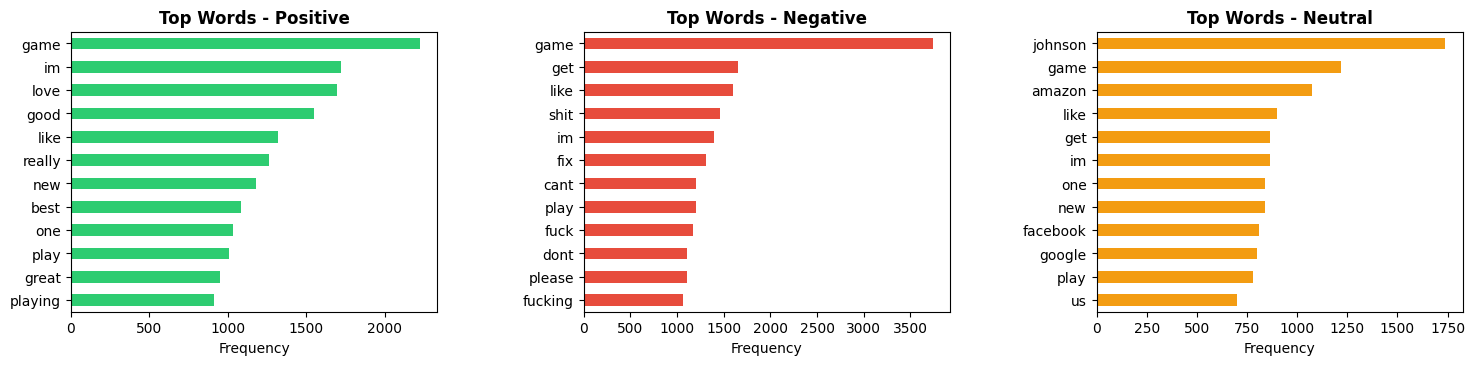

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
sentiments_list = ['Positive', 'Negative', 'Neutral']
colors_list = ['#2ecc71', '#e74c3c', '#f39c12']

for idx, sentiment in enumerate(sentiments_list):
    if sentiment in df['Sentiment'].values:
        sentiment_data = df[df['Sentiment'] == sentiment]['Processed_Text']
        all_words = []
        for text in sentiment_data:
            all_words.extend(text.split())
        
        if all_words:
            word_counts = Counter(all_words)
            top_words = pd.Series(dict(word_counts.most_common(12)))
            top_words.plot(kind='barh', ax=axes[idx], color=colors_list[idx])
            axes[idx].set_title(f'Top Words - {sentiment}', fontweight='bold')
            axes[idx].set_xlabel('Frequency')
        axes[idx].invert_yaxis()

plt.subplots_adjust(left=0.08, right=0.95, top=0.85, bottom=0.15, wspace=0.4)

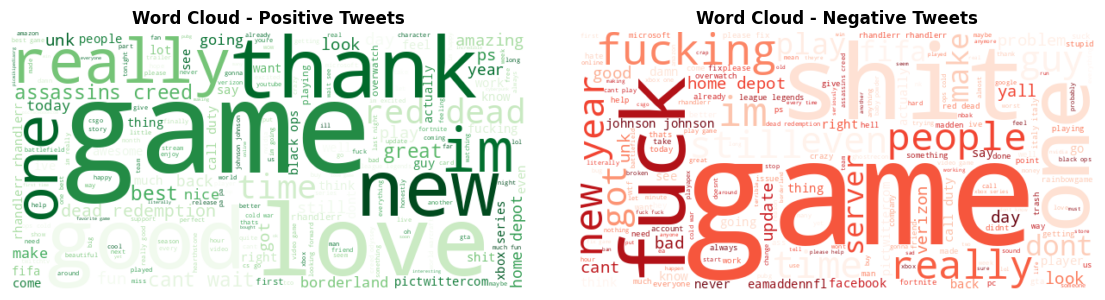

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

positive_text = ' '.join(df[df['Sentiment'] == 'Positive']['Processed_Text'].values)
if positive_text.strip():
    wc_positive = WordCloud(width=600, height=300, background_color='white', colormap='Greens').generate(positive_text)
    axes[0].imshow(wc_positive, interpolation='bilinear')
axes[0].set_title('Word Cloud - Positive Tweets', fontweight='bold')
axes[0].axis('off')

negative_text = ' '.join(df[df['Sentiment'] == 'Negative']['Processed_Text'].values)
if negative_text.strip():
    wc_negative = WordCloud(width=600, height=300, background_color='white', colormap='Reds').generate(negative_text)
    axes[1].imshow(wc_negative, interpolation='bilinear')
axes[1].set_title('Word Cloud - Negative Tweets', fontweight='bold')
axes[1].axis('off')

plt.subplots_adjust(wspace=0.1)

   [OK] Saved: 04_tweet_length_sentiment.png


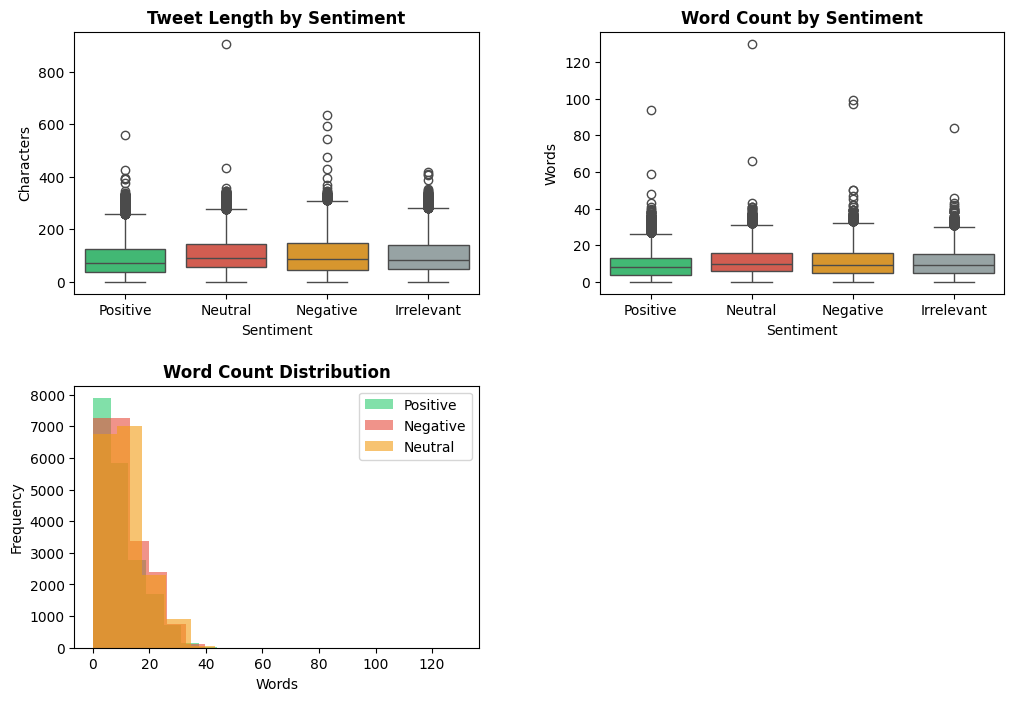

In [9]:
try:
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    sns.boxplot(data=df, x='Sentiment', y='Tweet_Length', ax=axes[0, 0], palette=colors[:len(sentiment_counts)])
    axes[0, 0].set_title('Tweet Length by Sentiment', fontweight='bold')
    axes[0, 0].set_ylabel('Characters')
    
    sns.boxplot(data=df, x='Sentiment', y='Word_Count', ax=axes[0, 1], palette=colors[:len(sentiment_counts)])
    axes[0, 1].set_title('Word Count by Sentiment', fontweight='bold')
    axes[0, 1].set_ylabel('Words')
    
    # Simpler histogram
    for sentiment, color in zip(sentiments_list, colors_list):
        if sentiment in df['Sentiment'].values:
            axes[1, 0].hist(df[df['Sentiment'] == sentiment]['Word_Count'], 
                             alpha=0.6, label=sentiment, bins=15, color=color)
    axes[1, 0].set_title('Word Count Distribution', fontweight='bold')
    axes[1, 0].set_xlabel('Words')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].legend()
    
    # Remove the fourth subplot
    fig.delaxes(axes[1, 1])
    
    plt.subplots_adjust(hspace=0.35, wspace=0.3)
    print("   [OK] Saved: 04_tweet_length_sentiment.png")
except Exception as e:
    print(f"   WARNING: Could not save sentiment vs length visualization: {str(e)}")

### SENTIMENT ANALYSIS - EDA SUMMARY

1. DATASET OVERVIEW:
   * Total tweets analyzed: 69,491
   * Data quality: 100.0% valid
   * Unique topics: 32
   * Topics range: Gaming, Tech, Social Media, Retail brands

2. SENTIMENT DISTRIBUTION:
   * Negative: 21,166 tweets (30.5%)
   * Positive: 19,067 tweets (27.4%)
   * Neutral: 17,042 tweets (24.5%)
   * Irrelevant: 12,216 tweets (17.6%)

3. TEXT CHARACTERISTICS:
   * Average tweet length: 100.77 characters
   * Average word count: 10.76 words
   * Longest tweet: 907 characters
   * Shortest tweet: 0 characters
   
4. VOCABULARY INSIGHTS:
   * Total unique words (after preprocessing): 37193
   * TF-IDF features extracted: 500
   * Features capture key vocabulary differences across sentiments
   

In [10]:
# Save processed data
df_output = df[['Tweet', 'Cleaned_Tweet', 'Sentiment', 'Topic', 'Word_Count', 'Tweet_Length']]
df_output.to_csv('processed_tweets.csv', index=False)

## Build RNNs
1. Prepare data

In [11]:
# Use cleaned tweets for better results
X = df['Cleaned_Tweet'].values
y = df['Sentiment'].values

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
le = label_encoder  # alias for later cells (keeps variable name consistent)
num_classes = len(np.unique(y_encoded))

# Tokenize text
max_vocab_size = 5000
max_sequence_length = 100

tokenizer = Tokenizer(num_words=max_vocab_size, oov_token='<OOV>')

# Convert to string type to ensure proper tokenization
X_clean = X.astype(str)
tokenizer.fit_on_texts(X_clean)
X_sequences = tokenizer.texts_to_sequences(X_clean)
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length, padding='post')

vocab_size_actual = len(tokenizer.word_index) + 1

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


2. Build RNN model

In [15]:
print("\n" + "="*70)
print("OPTIMIZED MODEL - IMPROVED ARCHITECTURE FOR BETTER ACCURACY")
print("="*70)

# Optimized hyperparameters
embedding_dim = 128
lstm_units = 100
dropout_rate = 0.4
recurrent_dropout = 0.2

batch_size = 32
epochs = 50
validation_split = 0.2
learning_rate = 0.001

print("\nHyperparameters:")
print(f"  • Embedding dim: {embedding_dim}")
print(f"  • LSTM units: {lstm_units}")
print(f"  • Dropout: {dropout_rate}, Recurrent dropout: {recurrent_dropout}")
print(f"  • Batch size: {batch_size}, Learning rate: {learning_rate}")

# Build optimized model
embedding_input_dim = min(max_vocab_size, vocab_size_actual)

model = Sequential([
    # Embedding Layer
    Embedding(input_dim=embedding_input_dim, 
              output_dim=embedding_dim, 
              input_length=max_sequence_length,
              mask_zero=True,
              name='embedding'),
    
    # First LSTM Layer with recurrent dropout
    LSTM(units=lstm_units, 
         return_sequences=True, 
         activation='relu',
         recurrent_dropout=recurrent_dropout,
         name='lstm_1'),
    
    # Batch normalization
    BatchNormalization(name='batch_norm_1'),
    
    # Spatial dropout for feature maps
    Dropout(dropout_rate, name='dropout_1'),
    
    # Second LSTM Layer
    LSTM(units=lstm_units//2, 
         return_sequences=False, 
         activation='relu',
         recurrent_dropout=recurrent_dropout,
         name='lstm_2'),
    
    # Batch normalization
    BatchNormalization(name='batch_norm_2'),
    
    # Dropout
    Dropout(dropout_rate, name='dropout_2'),
    
    # Dense layers
    Dense(128, activation='relu', name='dense_1'),
    BatchNormalization(name='batch_norm_3'),
    Dropout(dropout_rate, name='dropout_3'),
    
    Dense(64, activation='relu', name='dense_2'),
    Dropout(dropout_rate*0.8, name='dropout_4'),
    
    # Output layer
    Dense(num_classes, activation='softmax', name='output')
])

# Use Adam with gradient clipping for stability
optimizer = Adam(learning_rate=learning_rate, clipvalue=1.0)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\nb. Optimized Model Architecture:")
model.summary()
print("\n✓ Model rebuilt with improved architecture")


OPTIMIZED MODEL - IMPROVED ARCHITECTURE FOR BETTER ACCURACY

Hyperparameters:
  • Embedding dim: 128
  • LSTM units: 100
  • Dropout: 0.4, Recurrent dropout: 0.2
  • Batch size: 32, Learning rate: 0.001

b. Optimized Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_3                    │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


✓ Model rebuilt with improved architecture


3. Train the model

In [16]:
print("\n" + "="*70)
print("TRAINING WITH ADVANCED OPTIMIZATION TECHNIQUES")
print("="*70)

# Calculate class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print("\nClass Weights (to handle imbalance):")
for class_idx, weight in class_weight_dict.items():
    class_name = label_encoder.classes_[class_idx]
    print(f"  {class_name}: {weight:.3f}")

# Enhanced callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=7,
    restore_best_weights=True,
    verbose=1,
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

print("\nTraining Configuration:")
print(f"  • Batch size: {batch_size}")
print(f"  • Epochs: {epochs}")
print(f"  • Validation split: {validation_split}")
print(f"  • Early stopping: patience=7 on val_accuracy")
print(f"  • Learning rate reduction: enabled")

print("\nStarting training...")
print("-" * 70)

history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=validation_split,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("-" * 70)
print("\n✓ Training completed!")
print(f"  • Total epochs: {len(history.history['loss'])}")
print(f"  • Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"  • Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"  • Best validation accuracy: {max(history.history['val_accuracy']):.4f}")


TRAINING WITH ADVANCED OPTIMIZATION TECHNIQUES

Class Weights (to handle imbalance):
  Irrelevant: 1.422
  Negative: 0.821
  Neutral: 1.019
  Positive: 0.911

Training Configuration:
  • Batch size: 32
  • Epochs: 50
  • Validation split: 0.2
  • Early stopping: patience=7 on val_accuracy
  • Learning rate reduction: enabled

Starting training...
----------------------------------------------------------------------
Epoch 1/50
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 207s 142ms/step - accuracy: 0.3894 - loss: 1.3718 - val_accuracy: 0.5389 - val_loss: 1.2129 - learning_rate: 0.0010
Epoch 2/50
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 207s 142ms/step - accuracy: 0.3894 - loss: 1.3718 - val_accuracy: 0.5389 - val_loss: 1.2129 - learning_rate: 0.0010
Epoch 2/50
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 175s 126ms/step - accuracy: 0.5942 - loss: 1.0379 - val_accuracy: 0.6323 - val_loss: 0.9587 - learning_rate: 0.0010
Epoch 3/50
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 175s 126ms/step - accuracy: 0.5942 - loss: 1.0379 - val_accurac

4. EVALUATE MODEL

In [18]:
# Predictions
y_pred_probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("a. Performance Metrics:")
print(f"   - Accuracy:  {accuracy:.4f}")
print(f"   - Precision: {precision:.4f}")
print(f"   - Recall:    {recall:.4f}")
print(f"   - F1-Score:  {f1:.4f}")

print("\nb. Classification Report:")
print(classification_report(y_test, y_pred, 
                          target_names=label_encoder.classes_,
                          zero_division=0))

a. Performance Metrics:
   - Accuracy:  0.8351
   - Precision: 0.8362
   - Recall:    0.8351
   - F1-Score:  0.8353

b. Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.77      0.83      0.80      2443
    Negative       0.87      0.86      0.86      4233
     Neutral       0.84      0.80      0.82      3409
    Positive       0.84      0.85      0.84      3814

    accuracy                           0.84     13899
   macro avg       0.83      0.83      0.83     13899
weighted avg       0.84      0.84      0.84     13899




VISUALIZATION & DETAILED ANALYSIS


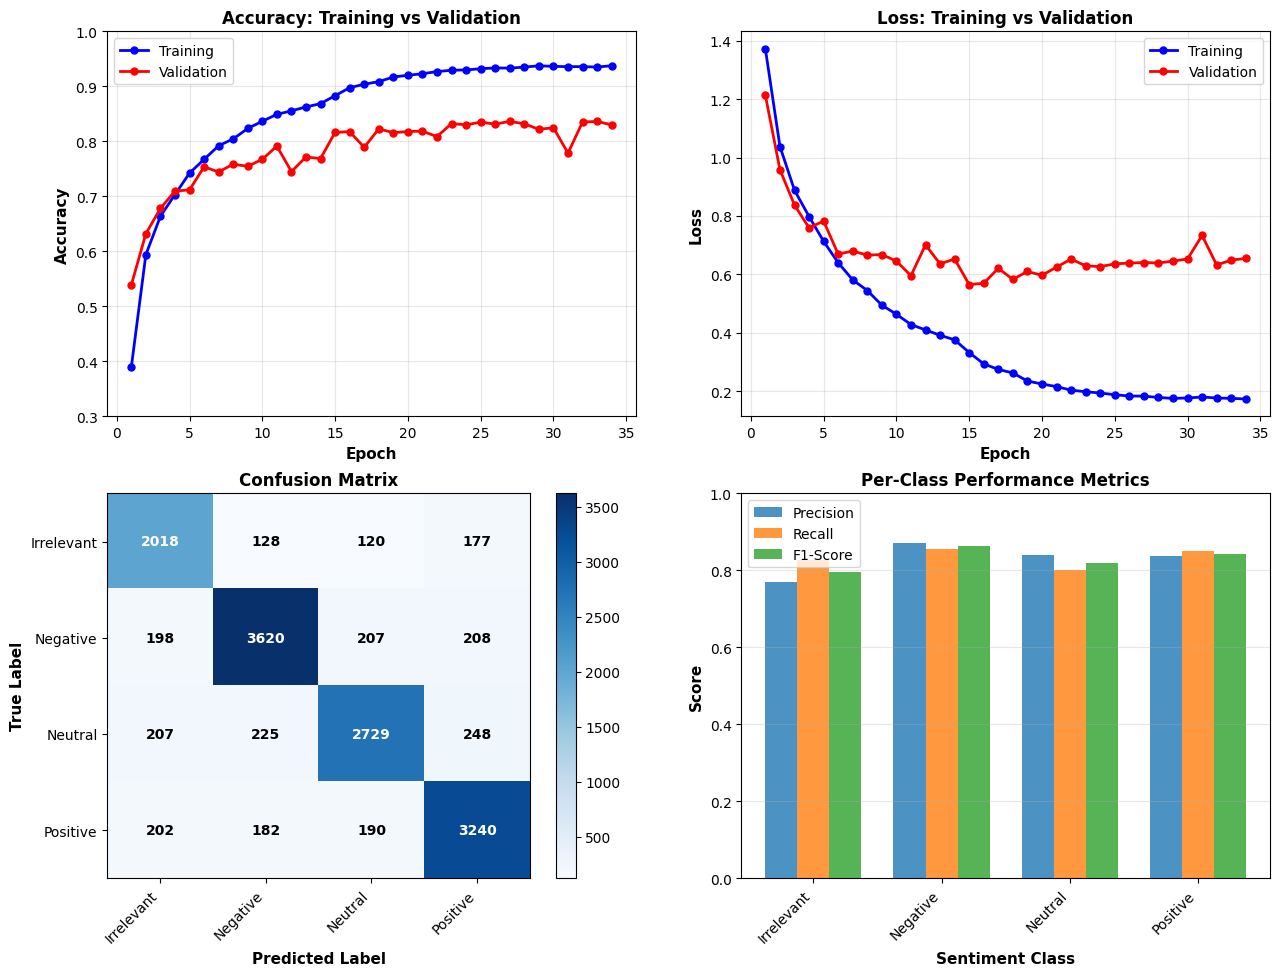

In [20]:
print("\n" + "="*70)
print("VISUALIZATION & DETAILED ANALYSIS")
print("="*70)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 11))

# Plot 1: Training vs Validation Accuracy
ax = axes[0, 0]
epochs_range = range(1, len(history.history['accuracy']) + 1)
ax.plot(epochs_range, history.history['accuracy'], 'b-o', label='Training', linewidth=2, markersize=5)
ax.plot(epochs_range, history.history['val_accuracy'], 'r-o', label='Validation', linewidth=2, markersize=5)
ax.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax.set_title('Accuracy: Training vs Validation', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim([0.3, 1.0])

# Plot 2: Training vs Validation Loss
ax = axes[0, 1]
ax.plot(epochs_range, history.history['loss'], 'b-o', label='Training', linewidth=2, markersize=5)
ax.plot(epochs_range, history.history['val_loss'], 'r-o', label='Validation', linewidth=2, markersize=5)
ax.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax.set_ylabel('Loss', fontsize=11, fontweight='bold')
ax.set_title('Loss: Training vs Validation', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 3: Confusion Matrix
ax = axes[1, 0]
cm = confusion_matrix(y_test, y_pred)
class_labels = label_encoder.classes_
im = ax.imshow(cm, cmap='Blues', aspect='auto')
ax.set_xticks(range(len(class_labels)))
ax.set_yticks(range(len(class_labels)))
ax.set_xticklabels(class_labels, rotation=45, ha='right')
ax.set_yticklabels(class_labels)
ax.set_ylabel('True Label', fontsize=11, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=11, fontweight='bold')
ax.set_title('Confusion Matrix', fontsize=12, fontweight='bold')

# Add text annotations
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        text = ax.text(j, i, str(cm[i, j]), ha="center", va="center", 
                      color="white" if cm[i, j] > cm.max() / 2 else "black", fontsize=10, fontweight='bold')
plt.colorbar(im, ax=ax)

# Plot 4: Per-Class Metrics
ax = axes[1, 1]
classes = label_encoder.classes_
from sklearn.metrics import precision_recall_fscore_support
precision_arr, recall_arr, f1_arr, _ = precision_recall_fscore_support(y_test, y_pred)

x = np.arange(len(classes))
width = 0.25
bars1 = ax.bar(x - width, precision_arr, width, label='Precision', alpha=0.8)
bars2 = ax.bar(x, recall_arr, width, label='Recall', alpha=0.8)
bars3 = ax.bar(x + width, f1_arr, width, label='F1-Score', alpha=0.8)

ax.set_xlabel('Sentiment Class', fontsize=11, fontweight='bold')
ax.set_ylabel('Score', fontsize=11, fontweight='bold')
ax.set_title('Per-Class Performance Metrics', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45, ha='right')
ax.set_ylim([0, 1])
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')


plt.show()

